# Assignment 6

In [1]:
from chainer import Chain
import chainer.links as L
import chainer.functions as F
import chainer.optimizers as optimizers
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils import get_mnist, RandomIterator

For this assignment, we had to implement a GAN structure. We will first give the network structures for both:

In [2]:
class GenerativeMLP(Chain):
	def __init__(self, n_hidden):
		super(GenerativeMLP, self).__init__()
		with self.init_scope():
			self.fc1 = L.Linear(None, n_hidden)  # Fully Connected Layer
			self.fc2 = L.Linear(n_hidden, n_hidden)
			self.fc3 = L.Linear(n_hidden, 28*28)

	def __call__(self, x):
		fc1_out = F.elu(self.fc1(x))
		fc2_out = F.sigmoid(self.fc2(fc1_out))
		fc3_out = self.fc3(fc2_out)
		return fc3_out


class DiscriminativeMLP(Chain):
	def __init__(self, n_hidden):
		super(DiscriminativeMLP, self).__init__()
		with self.init_scope():
			self.fc1 = L.Linear(784, n_hidden)  # Fully Connected Layer
			self.fc2 = L.Linear(n_hidden, n_hidden)
			self.fc3 = L.Linear(n_hidden, 2)

	def __call__(self, x):
		fc1_out = F.elu(self.fc1(x))
		fc2_out = F.elu(self.fc2(fc1_out))
		fc3_out = F.sigmoid(self.fc3(fc2_out))
		return fc3_out

The training of the model is through the following function:

In [3]:
def train():
	discriminative_optimizer = optimizers.SGD()
	discriminative_optimizer.setup(discriminative_net)

	generative_optimizer = optimizers.SGD()
	generative_optimizer.setup(generative_net)

	loss_disc = []
	loss_gen = []
	for _ in tqdm(range(n_iter)):
		loss_disc_current = 0
		loss_gen_current = 0
		for data in train_iter:
		
			x_real = data
			t_real = discriminative_net(x_real)

			gen_input = np.float32(np.random.uniform(size=(batch_size, 1)))
			x_fake = generative_net(gen_input)
			t_fake = discriminative_net(x_fake)

			# Backprop
			generative_loss = F.softmax_cross_entropy(t_fake, np.ones(shape=(batch_size), dtype=np.int32))
			discriminative_loss = F.softmax_cross_entropy(t_fake, np.zeros(shape=(batch_size), dtype=np.int32))
			discriminative_loss += F.softmax_cross_entropy(t_real, np.ones(shape=(batch_size), dtype=np.int32))
			discriminative_loss /= 2
			
			generative_net.cleargrads()
			generative_loss.backward()  # recompute the grads
			generative_optimizer.update()

			discriminative_net.cleargrads()
			discriminative_loss.backward()
			discriminative_optimizer.update()

			loss_disc_current += discriminative_loss.data
			loss_gen_current += generative_loss.data

		loss_gen.append(loss_gen_current/train_iter.idx)
		loss_disc.append(loss_disc_current/train_iter.idx)

	plt.plot(loss_disc, label="Discriminator Loss")
	plt.plot(loss_gen, label="Generator Loss")
	plt.legend()
	plt.ylabel("Loss")
	plt.xlabel("Epoch")
	plt.show()
	for i in range(9):
		gen_input = np.float32(np.random.uniform(size=[1, 1]))
		generation = generative_net(gen_input)  # we need to keep the variable type around, to compute stuff

		plt.imshow(np.reshape(generation.data, newshape=[28, 28]).transpose())
		plt.show()

The function above trains two seperate networks, the Generative model and the Discriminative model. Afterwards it plots the loss of both networks and gives ten samples that are generated by the generative model.

# MLP models
We will first examine the case where both, the discriminator and generator models are MLP networks as given above. We will examine different cases for these networks:
 * Same number of hidden units for both networks
   * Low amount of hidden units
   * High amount of hidden units
 * Generator has more hidden units
 
## Same Number of Hidden Units
### High Amount of Hidden Units

100%|████████████████████████████████████████| 100/100 [00:20<00:00,  4.85it/s]


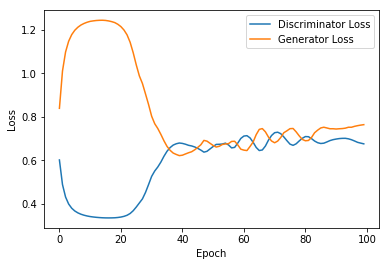

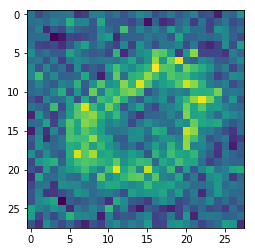

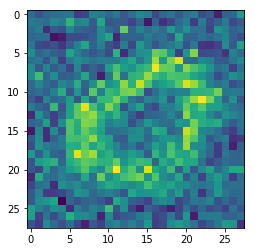

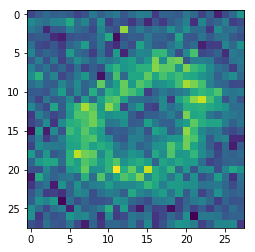

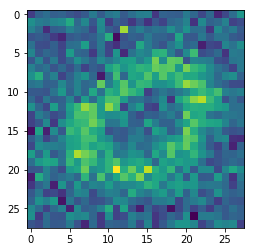

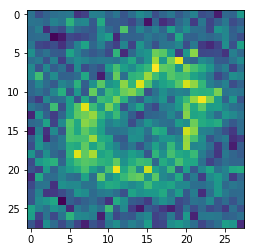

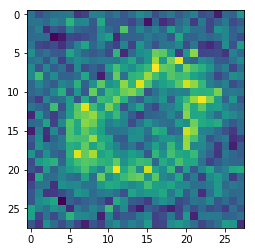

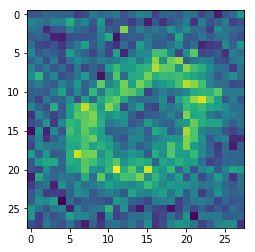

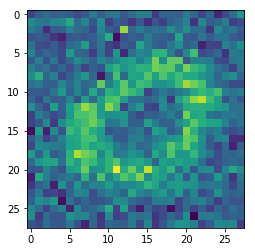

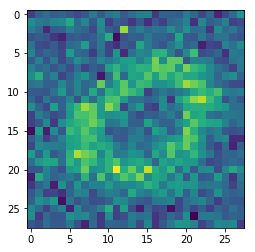

In [4]:
n_iter = 100
batch_size = 50
train_data, test_data = get_mnist(n_train=1000, n_test=100, with_label=False, classes=[0], n_dim=3)
train_iter = RandomIterator(train_data, batch_size)
test_iter = RandomIterator(test_data, batch_size)

discriminative_net = DiscriminativeMLP(n_hidden=100)
generative_net = GenerativeMLP(n_hidden=100)

train()

### Low Amount of Hidden Units

100%|████████████████████████████████████████| 100/100 [00:15<00:00,  6.39it/s]


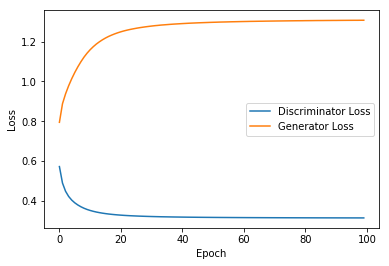

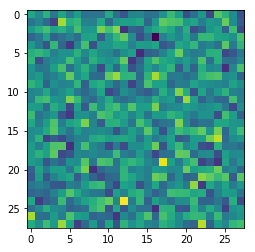

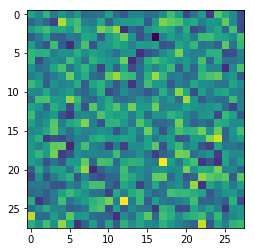

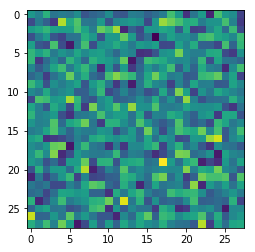

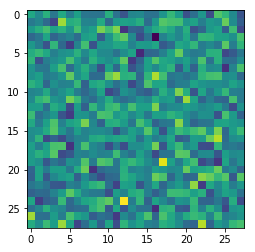

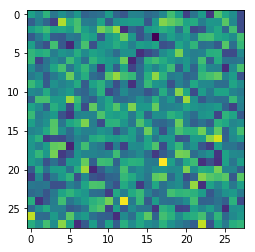

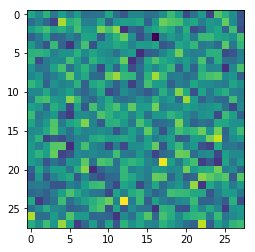

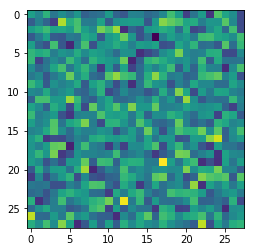

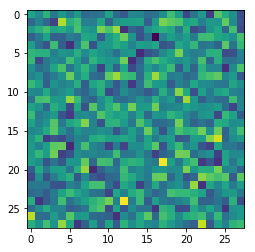

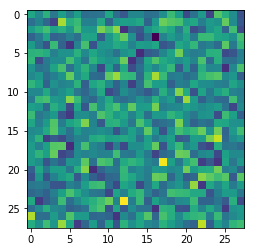

In [5]:
discriminative_net = DiscriminativeMLP(n_hidden=10)
generative_net = GenerativeMLP(n_hidden=10)

train()

### Loss
In the plot for the high number of hidden units, we can see the beautifull minimax game between the networks. We see that the discriminator starts of with a strong decrease in loss, meaning that the network quickly recognises what inputs are fake and which are not. This explains the rise in loss for the generative model, since it performs poorly at first.

However, when the generative model becomes better, we see that the the loss decreases for the generative model and increase for the discriminator model. After Epoch 40, the losses do not change that much.

What can be observed overal is that there is a strong negative correlation between the losses for both models, which can be expected from GANs.

From the plot for the low number of hidden units, we may conlcude that the discriminator needs more hidden units than the discriminator. This makes sense, since generating an image is much more complex than classifying it as "real" or "fake". This led to our hypothesis that if the generative network is poor, the network cannot generate good images.

### MLP network
When we look at the generated samples, we may distinguish that these represent zeros. However, we can still clearly see that the zeros are not handwritten due to the noise that is present in the samples. However, for the generated samples belonging to the low amount of hidden units, we cannot distinguish anything from the images.

## Generator More Hidden Units

100%|████████████████████████████████████████| 100/100 [00:20<00:00,  4.91it/s]


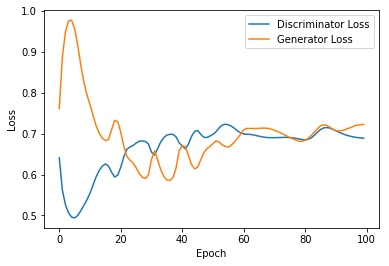

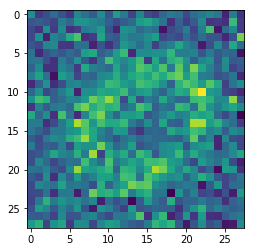

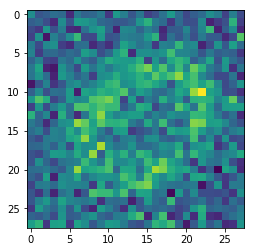

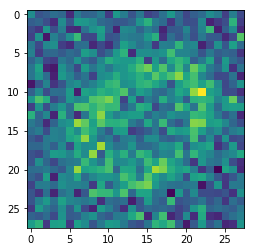

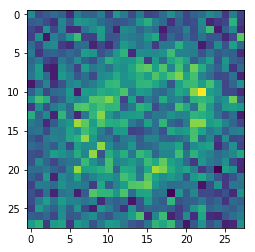

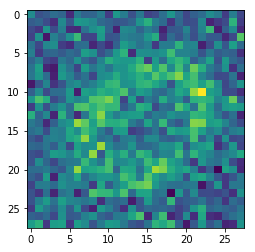

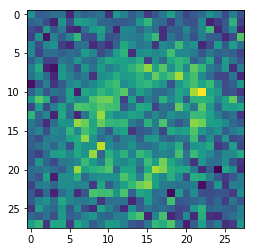

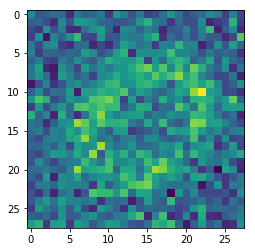

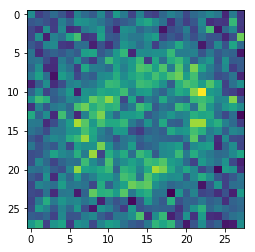

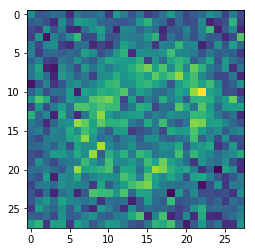

In [6]:
discriminative_net = DiscriminativeMLP(n_hidden=10)
generative_net = GenerativeMLP(n_hidden=200)

train()

What we may conclude from the results above is that the generator indeed needs less hidden units than the discriminator. However, the quality of the generated samples, did not (significantly) increase over having 200 hidden units rather than 100.

## Convolutional
We also wanted to see what the results were if we would use a more complex generator and discriminator. To this end we propose a beefy generator network with one fully connected and three deconvolutional layers where each layer would get Batch Normalisation. And a Discriminator model with one convolutional layer followed by a max-pooling layer and a fully connected layer:

In [7]:
class GenerativeDeconvolutional(Chain):
	def __init__(self, n_hidden):
		super(GenerativeDeconvolutional, self).__init__()
		with self.init_scope():
			self.n_hidden = n_hidden
			self.fc0 = L.Linear(None, n_hidden)  # Fully Connected Layer
			self.deconv1 = L.Deconvolution2D(n_hidden, 128, 4, stride=2, pad=1)  # Deconvolutional Layer
			self.deconv2 = L.Deconvolution2D(128, 64, 4, stride=2, pad=1)  # Deconvolutional Layer
			self.deconv3 = L.Deconvolution2D(64, 1, 24, stride=2, pad=1)  # Deconvolutional Layer
			self.bn0 = L.BatchNormalization(n_hidden)  # Batch Normalisation Computation
			self.bn1 = L.BatchNormalization(128)  # Batch Normalisation Computation
			self.bn2 = L.BatchNormalization(64)  # Batch Normalisation Computation

	def __call__(self, x):
		h = F.relu(self.bn0(self.fc0(x)))
		h = F.reshape(h, (x.shape[0],) + (self.n_hidden, 1, 1))
		h = F.relu(self.bn1(self.deconv1(h)))
		h = F.relu(self.bn2(self.deconv2(h)))
		h = F.sigmoid(self.deconv3(h))

		return h


class DiscriminativeConvolutional(Chain):
	def __init__(self, n_feature_maps=5):
		super(DiscriminativeConvolutional, self).__init__()
		with self.init_scope():
			self.conv = L.Convolution2D(None, n_feature_maps, ksize=5)  # Convolutional Layer
			self.lin = L.Linear(None, 2)  # Linear Readout Layer

	def __call__(self, x):
		conv_output = F.relu(self.conv(x))
		max_pooling_output = F.max_pooling_2d(conv_output, ksize=2)
		lin_output = self.lin(max_pooling_output)

		return lin_output

We will run these networks with the following parameters:

In [8]:
n_iter = 100
discriminative_net = DiscriminativeConvolutional()
generative_net = GenerativeDeconvolutional(256)

And then we let them loose:

100%|████████████████████████████████████████| 100/100 [02:54<00:00,  1.74s/it]


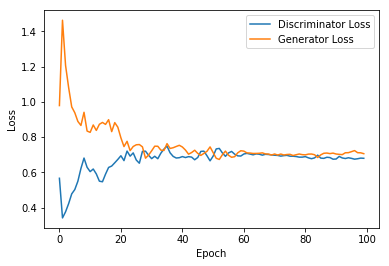

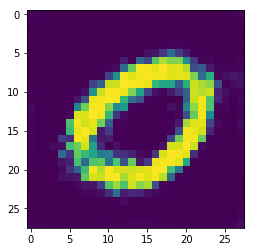

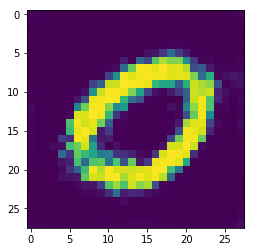

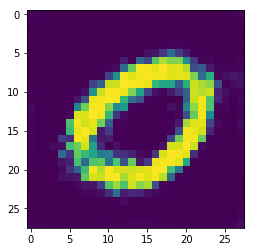

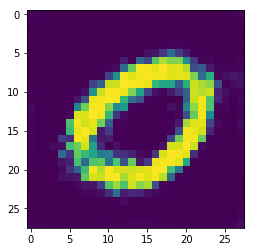

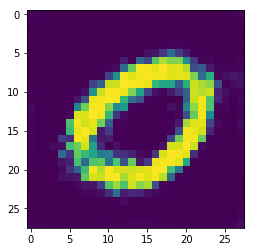

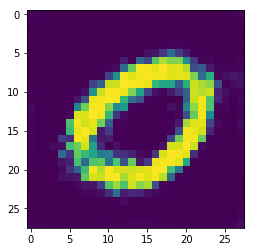

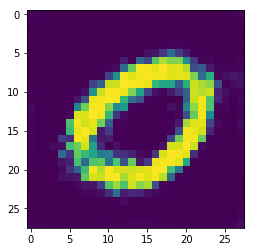

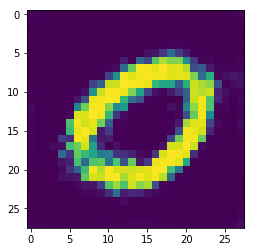

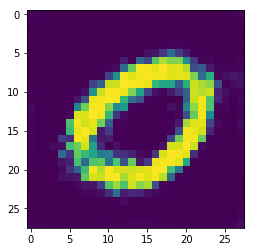

In [9]:
train()

What we can see from the loss plot, is that both networks are quicker to converge and their loss curves are not as smooth as their MLP counterparts, which had almost sinusoid shapes. We can also see that the networks do not learn much after epoch 60, where they almost have equilibrium.

Looking at the generated samples we can make an educated guess why, the generated samples resemble almost exact handwritten digits. One thing that is worth pointing out is that the generated digits look really similar to each other, dispite the generator getting uniform distributed random data is input.